# AI_campus_ProstateSeg 
# Module 8: Unsupervised Image Segmentation Using DBSCAN
### PANDA: Prostate cANcer graDe Assessment (PANDA) Challenge

In continuation of the previous module (Module 7), this notebook walks through another example of unsupervised image segmentation using DBSCAN (Density-Bases Spatial Clustering of Applications with Noise). In unsupervised machine learning, a model learns patterns from the data itself without relying on any external supervisory signal in the form of class labels, which in this case are the segmentation masks corresponding to each image. The DBSCAN clustering algorithm is a density based clustering algorithm, unlike K-means, which is a centroid based clustering algorithm. DBSCAN groups data based on their density, and it can detect clusters of arbitrary shape while being robust to outliers (which are formally considered noisy), whereas K-means tends to detect clusters of spherical shape. The DBSCAN clustering algorithm requires two parameters: epsilon (ε), which defines the maximum distance between two points to be considered neighbors, and minPts, the minimum number of points required to form a dense region (cluster). Unlike K-means, the DBSCAN algorith does not require the number of clusters to be pre-defined and user-set. The algorithm starts by selecting an arbitrary unvisited point, and if it has enough neighbors within epsilon distance, it forms a new cluster. Points that are not part of any cluster and don't have enough neighbors are labeled as noise. DBSCAN is particularly effective at identifying clusters of arbitrary shape and is robust to outliers. Since our images have 3 channels (Red, Gree, and Blue), each location/point in the image can be featurized as a 3-dimensional vector, where the Red, Green and Blue pixel values that define it are stored. Then, the DBSCAN algorithm can be applied to the image, expressed as a (N, D) matrix. Where N is the number of points in the image, and D corresponds to the number of pixel values that define each point in the image, which is 3 in case of RGB images. In case of a tile of size (224, 224, 3), we reshape the tensor to be of dimensionality (224 * 224, 3) = (50176, 3), and apply the DBSCAN clustering algorithm to it. 

## 1. Import the necessary packages

In [12]:
import os
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import panda_utils as putil
import torch
import torchvision.transforms as transforms
import cv2

from PIL import Image
from typing import List, Set, Union, Optional, Dict, Tuple
from torch.utils.data import Dataset
from dataclass import ToyPANDASDataset
from torchvision.transforms import functional as F
from scipy.stats import entropy
from normalizers import ChannelWiseMinMaxNormalizer
from sklearn.cluster import DBSCAN

## 2. Define folder and subdirectory folder names

In [2]:
ROOT_FOLDER = "sample_data"
IMAGE_SUBFOLDER = "train_images"
MASK_SUBFOLDER = "train_label_masks"

image_dir = os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER)
mask_dir = os.path.join(ROOT_FOLDER, MASK_SUBFOLDER)

## 3. Create list of image and mask files and print contents

In [3]:
image_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(image_dir))))
mask_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(mask_dir))))

In [4]:
image_files

['0018ae58b01bdadc8e347995b69f99aa.tiff',
 '004dd32d9cd167d9cc31c13b704498af.tiff',
 '0068d4c7529e34fd4c9da863ce01a161.tiff',
 '006f6aa35a78965c92fffd1fbd53a058.tiff',
 '007433133235efc27a39f11df6940829.tiff',
 '0076bcb66e46fb485f5ba432b9a1fe8a.tiff',
 '008069b542b0439ed69b194674051964.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb.tiff',
 '00951a7fad040bf7e90f32e81fc0746f.tiff',
 '00a26aaa82c959624d90dfb69fcf259c.tiff']

In [5]:
mask_files

['0018ae58b01bdadc8e347995b69f99aa_mask.tiff',
 '004dd32d9cd167d9cc31c13b704498af_mask.tiff',
 '0068d4c7529e34fd4c9da863ce01a161_mask.tiff',
 '006f6aa35a78965c92fffd1fbd53a058_mask.tiff',
 '007433133235efc27a39f11df6940829_mask.tiff',
 '0076bcb66e46fb485f5ba432b9a1fe8a_mask.tiff',
 '008069b542b0439ed69b194674051964_mask.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb_mask.tiff',
 '00951a7fad040bf7e90f32e81fc0746f_mask.tiff',
 '00a26aaa82c959624d90dfb69fcf259c_mask.tiff']

### 6. Write function to draw mask on an image given a boolean mask and class labels

In [6]:
def draw_mask(image: np.ndarray, 
              mask: np.ndarray,
              color_rgb_list: List[int] = [0, 255, 0]):
    
    """
    Function to draw mask on an image based on the
    mask given (mask). The mask will be translucent
    green given the default color in color_rgb_list = [0, 225, 0]
    
    Parameters
    -----------
    image: np.ndarray
        The image over which the mask is to be overlayed
    
    mask: np.ndarray
        The mask that is to be overlayed on the image. 
        This mask must be boolean (containing only True or False)
        
    color_rgb_list: List[int]
        The RGB pixel configuration of the color of the translucent
        mask to overlay on the image. 
        Default = [0, 255, 0] (green)
    
    Returns
    ---------
    np.ndarray
        The image with the colored mask overlaid along the 
        pixel locations which indicate True in the mask. 
    
    """
    
    masked_image = image.copy()
    masked_image = np.where(mask.astype(int),
                            np.array(color_rgb_list, dtype='uint8'),
                            masked_image)

    masked_image = masked_image.astype(np.uint8)

    return cv2.addWeighted(image, 0.3, masked_image, 0.7, 0)

### 7. Write function to plot segmented image by label

In [7]:
def plot_segmented_image_by_label(image: np.ndarray,
                                  mask: np.ndarray,
                                  label_id: int):
    
    """
    Function to plot segmented image by label.
    Given an image and mask pair, the function
    plots the image by applying the segmentation
    mask for a specific label. The mask contains
    integers values to represent the different class
    labels. The function only applies segmentation
    mask for pixel locations where that label_id is
    present.
    
    Parameters
    -----------
    image: np.ndarray
        The input image.
    
    mask: np.ndarray
        The mask with integer labels.
    
    label_id: int
        The class label, represented as an integer
    
    Returns
    ---------
    Plots the image with segmentation mask applied
    to the pixel locations where the given label_id
    is present. 
    
    """
    
    avail_labels = list(putil.enlist_class_presence(mask))
    assert label_id in avail_labels
    
    assert image.shape == mask.shape
    assert image.shape[-1] == 3 and mask.shape[-1] == 3
    
    assert np.sum(mask[:,:,1]) == 0 and np.sum(mask[:,:,2]) == 0
    
    if np.sum(mask[:,:,0]) == 0:
        print("The image is all background")
    
    reduced_mask = mask[:, :, 0]
    assert len(reduced_mask.shape) == 2
    
    assert set(list(np.unique(reduced_mask))) == set(avail_labels)
    
    boolean_label_mask = reduced_mask == label_id
    assert (reduced_mask == label_id).sum() == boolean_label_mask.sum()
    
    n_on_bits_for_label = (reduced_mask == label_id).sum()
    
    boolean_label_mask_3d = np.repeat(boolean_label_mask[:, :, np.newaxis], 3, axis=2)
    
    for i in range(3):
        assert np.sum(boolean_label_mask_3d[:, :, i]) == n_on_bits_for_label
        
    segmented_image = draw_mask(image, boolean_label_mask_3d)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    ax[0].imshow(image)
    ax[0].set_title('Original Image')  
    ax[0].axis('on')  

    ax[1].imshow(segmented_image)
    ax[1].set_title(f'Segmented Image by label_id: {label_id}')  
    ax[1].axis('on')  

    plt.tight_layout()

    plt.show()

### 9. Write function to apply segment to image by a label

In [8]:
def apply_segment_to_image_by_label(image,
                                    mask,
                                    label_id,
                                    color_lst):
    
    """
    Function to apply segmentation mask to image
    for a specific label_id
    
    Parameters
    -----------
    image: np.ndarray
        The image to which the segmentation mask is to
        be applied for that specific label_id
    
    mask: np.ndarray
        The mask which is to be applied to the image
        where the label_id is present
    
    label_id: int
        The label_id that is to be applied to the
        image from the segmentation mask
    
    color_lst: List[int]
        The color, expressed as list of RGB integer values,
        to be applied to the image where the label_id is
        present in the corresponding segmentation mask
    
    Returns
    --------
    np.ndarray
        The image with the segmentation mask applied
        at the pixel locations where label_id is present
        
    """
    
    avail_labels = list(putil.enlist_class_presence(mask))
    #assert label_id in avail_labels
    
    assert image.shape == mask.shape
    assert image.shape[-1] == 3 and mask.shape[-1] == 3
    
    assert np.sum(mask[:,:,1]) == 0 and np.sum(mask[:,:,2]) == 0
    
    if np.sum(mask[:,:,0]) == 0:
        print("The image is all background")
    
    reduced_mask = mask[:, :, 0]
    assert len(reduced_mask.shape) == 2
    
    assert set(list(np.unique(reduced_mask))) == set(avail_labels)
    
    boolean_label_mask = reduced_mask == label_id
    assert (reduced_mask == label_id).sum() == boolean_label_mask.sum()
    
    n_on_bits_for_label = (reduced_mask == label_id).sum()
    
    boolean_label_mask_3d = np.repeat(boolean_label_mask[:, :, np.newaxis], 3, axis=2)
    
    for i in range(3):
        assert np.sum(boolean_label_mask_3d[:, :, i]) == n_on_bits_for_label
        
    segmented_image = draw_mask(image, boolean_label_mask_3d, color_rgb_list = color_lst)
    
    return segmented_image

### 10. Write function to apply segment to image by multiple labels

In [78]:
def apply_segment_to_image_by_multiple_labels(image: np.ndarray,
                                              mask: np.ndarray,
                                              label_ids: List[int],
                                              color_rgb_pixels: List[list[int,int,int]] = [[0, 255, 0],
                                                                                           [255, 0, 0],
                                                                                           [0, 0, 255],
                                                                                           [255, 255, 0],
                                                                                           [255, 0, 255],
                                                                                           [0, 255, 255],
                                                                                           [255, 165, 0],
                                                                                           [128, 0, 128],
                                                                                           [139, 69, 19],
                                                                                           [255, 192, 203],
                                                                                           [169, 169, 169],
                                                                                           [245, 245, 220]],
                                              colors: List[str] = ["green",
                                                                    "red",
                                                                    "blue",
                                                                    "yellow",
                                                                    "magenta",
                                                                     "cyan",
                                                                    "orange",
                                                                     "purple",
                                                                      "brown",
                                                                       "pink",
                                                                        "gray",
                                                                        "beige"],
                                              
                                              id_to_class: Dict[int, str] = {0:"background (non tissue) or unknown",
                                                                             1:"stroma (connective tissue, non-epithelium tissue)",
                                                                             2: "healthy (benign) epithelium",
                                                                             3: "cancerous epithelium (Gleason 3)",
                                                                             4: "cancerous epithelium (Gleason 4)",
                                                                             5: "cancerous epithelium (Gleason 5)"},
                                               print_color: bool = False) -> np.ndarray:
    
    for i in range(len(label_ids)):
        image = apply_segment_to_image_by_label(image = image,
                                                mask = mask,
                                                label_id = label_ids[i],
                                                color_lst = color_rgb_pixels[i])
        if print_color:
            print(f"{colors[i]} : {id_to_class[label_ids[i]]}")
    
    return image

In [10]:
# Define id_to_class dictionary

id_to_class = {0: "background (non tissue) or unknown",
               1: "stroma (connective tissue, non-epithelium tissue)",
               2: "healthy (benign) epithelium",
               3: "cancerous epithelium (Gleason 3)",
               4: "cancerous epithelium (Gleason 4)",
               5: "cancerous epithelium (Gleason 5)"}

### 11. Write function to generate segmentation mask by K-Means algorithm

In [27]:
def generate_dbscan_segmentation_mask(image: np.ndarray,
                                      mask: np.ndarray,
                                      eps: Union[str, float] = "default",
                                      min_samples: Union[str, int] = "default"):
    
    if isinstance(eps, float) and isinstance(min_samples, int):
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
    elif isinstance(eps, float) and min_samples == "default":
        dbscan = DBSCAN(eps = eps)
    elif isinstance(min_samples, int) and eps == "default":
        dbscan = DBSCAN(min_samples = min_samples)
    else:
        dbscan = DBSCAN()
    
    image_size = image.shape[0]
    n_channels = image.shape[-1]
    pixels = image.reshape(-1, 3)
    
    dbscan.fit(pixels)
    labels = dbscan.labels_
    
    if -1 in labels:
        labels = 1 + labels
    
    dbscan_segmentation_mask = labels.reshape(image_size, image_size)
    processed_dbscan_segmentation_mask = np.zeros((image_size, image_size, n_channels))
    processed_dbscan_segmentation_mask[:, :, 0] = dbscan_segmentation_mask
    
    return processed_dbscan_segmentation_mask

### 12. Write function to normalize tile

In [28]:
def normalize_tile(tile,
                   min_vals = [0,0,0],
                   max_vals = [255,255,255]):
    
    assert tile.shape[-1] == 3
    
    if not torch.is_tensor(min_vals):
        min_vals = torch.tensor(min_vals)
    if not torch.is_tensor(max_vals):
        max_vals = torch.tensor(max_vals)
    
    normalizer = ChannelWiseMinMaxNormalizer(min_values = min_vals,
                                             max_values = max_vals)
    tile = torch.tensor(tile)
    tile = tile.unsqueeze(0).permute(0, 3, 1, 2)
    tile = normalizer.transform(tile)
    tile = tile.squeeze(0).permute(1,2,0)
    
    return tile.numpy()

### 13. Re-write function to mine highest entropy tile

In [29]:
def mine_highest_entropy_tile(image: np.ndarray,
                              mask: np.ndarray,
                              tile_size: int = 512) -> Tuple[float, float, np.ndarray, np.ndarray, List[float]]:
    """
    Mine highest entropy tile from an image and mask pair. The tile will have the
    highest entropy with respect to the distribution of classes present in the
    corresponding mask. The algorithm will repetitively calculate the entropy
    for each tile and update the max_entropy_tile and max_entropy_tile_mask as
    and when a tile with higher entropy is encountered. 
    
    Parameters
    -----------
    image: np.ndarray
        The image of arbitrary size
    
    mask: np.ndarray
        The mask with the same dimensionality
        as the image.
    
    tile_size: int
        The size of the square tiles to extract
        from the image. (Default = 512)
    
    Returns
    --------
    Tuple[float, float, np.ndarray, np.ndarray, List[float]]
    
    Returns the following from the tile-wise scan:
    
    max_entropy: float
        The maximum entropy of all the tiles of size tile_size x tile_size
        that are available in the image.
    
    min_entropy: float
        The minimum entropy of all the tiles of size tile_size x tile_size
        that are available in the image.
    
    max_entropy_tile: np.ndarray
        The maximum entropy tile from all the tiles scanned. This is 
        a numpy array of size tile_size x tile_size. 
    
    max_entropy_tile_mask: np.ndarray
        The maximum entropy tile mask scanned from all the tile masks.
        It has the same coordinates as the max_entropy_tile, and is
        of shape tile_size x tile_size. 
    
    tile_class_distribution_entropies: List[float]
        The entropy values of all the tiles scanned. 
    """
    
    max_entropy = -np.inf
    max_entropy_tile = None
    max_entropy_tile_mask = None
    n_tiles_scanned = 0
    available_classes = list(putil.enlist_class_presence(mask))
    tile_class_distribution_entropies = []
    
    R, C, n_channels = image.shape
    for i in range(0, R, tile_size):
        for j in range(0, C, tile_size):
            try:
                tile = image[i: i + tile_size, j: j + tile_size, :]
                if tile.shape == (tile_size, tile_size, n_channels):
                    n_tiles_scanned += 1
                    tile_mask = mask[i: i + tile_size, j: j + tile_size, :]
                    class_distribution = putil.summarize_class_distribution(tile_mask)
                    current_tile_entropy = entropy(list(class_distribution.values()))
                    tile_class_distribution_entropies.append(current_tile_entropy)
                    
                    if current_tile_entropy > max_entropy:
                        max_entropy = current_tile_entropy
                        max_entropy_tile = tile
                        max_entropy_tile_mask = tile_mask
            except IndexError:
                print(f"Skipping tile at position ({i}, {j}) because it is out of bounds.")
    
    min_entropy = min(tile_class_distribution_entropies)
    assert max_entropy == max(tile_class_distribution_entropies)
    
    max_entropy_tile_classes = set(list(putil.enlist_class_presence(max_entropy_tile_mask)))
    
    print(f"Number of {tile_size}-sized tiles scanned: {n_tiles_scanned}")
    
        
    return max_entropy, min_entropy, max_entropy_tile, max_entropy_tile_mask, tile_class_distribution_entropies

### Re-write function to plot ground truth and DBSCAN generated segmentation results

In [48]:
def plot_ground_truth_dbscan_segmentation_results(input_image: np.ndarray,
                                                  input_mask: np.ndarray,
                                                  tile_size: int = 224,
                                                  eps = "default",
                                                  min_samples = "default"):
    
    max_entropy, min_entropy, max_entropy_tile, max_entropy_tile_mask, _ = mine_highest_entropy_tile(image = input_image,
                                                                                                     mask = input_mask,
                                                                                                     tile_size = tile_size)

    normalized_max_entropy_tile = normalize_tile(max_entropy_tile)

    label_ids = list(putil.enlist_class_presence(max_entropy_tile_mask))

    ground_truth_segmented_image = apply_segment_to_image_by_multiple_labels(image = max_entropy_tile,
                                                                             mask = max_entropy_tile_mask,
                                                                             label_ids = label_ids,
                                                                             print_color = True)


    processed_dbscan_segmentation_mask = generate_dbscan_segmentation_mask(image = normalized_max_entropy_tile,
                                                                           mask = max_entropy_tile_mask,
                                                                           eps = eps,
                                                                           min_samples = min_samples)
    
    cluster_label_ids = putil.enlist_class_presence(processed_dbscan_segmentation_mask.astype(int))
    print(cluster_label_ids)

    dbscan_segmented_image = apply_segment_to_image_by_multiple_labels(image = max_entropy_tile,
                                                                       mask = processed_dbscan_segmentation_mask,
                                                                       label_ids = cluster_label_ids)


    fig, ax = plt.subplots(1, 3, figsize=(12, 6))

    ax[0].imshow(max_entropy_tile)
    ax[0].set_title('Original Image')  
    ax[0].axis('off')  

    ax[1].imshow(ground_truth_segmented_image)
    ax[1].set_title(f'Ground Truth Segmented Image')  
    ax[1].axis('off')  

    ax[2].imshow(dbscan_segmented_image)
    ax[2].set_title(f'DBSCAN Segmented Image')  
    ax[2].axis('off')  


    plt.tight_layout()

    plt.show()

### 14. Apply DBSCAN clustering to maximum entropy tiles sized 224 by 224 from different images and plot results alongside ground truth segmentation mask

Number of 224-sized tiles scanned: 2938
green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 4)
[0 1]


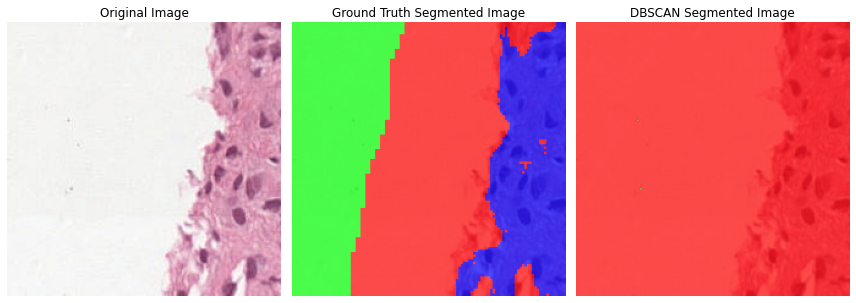

In [57]:
mask_file = mask_files[0]
image_file = image_files[0]
tile_size = 224


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_dbscan_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size,
                                              eps = 0.05,
                                              min_samples = 3)

Number of 224-sized tiles scanned: 3600
green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : healthy (benign) epithelium
[0]
The image is all background


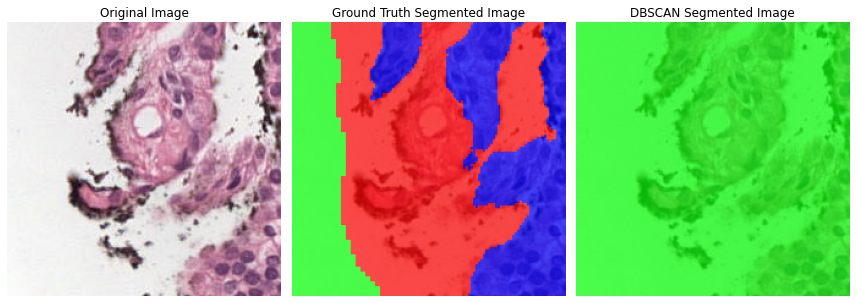

In [60]:
mask_file = mask_files[1]
image_file = image_files[1]
tile_size = 224


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_dbscan_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size)

Number of 224-sized tiles scanned: 1380
green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : healthy (benign) epithelium
[0 1 2]


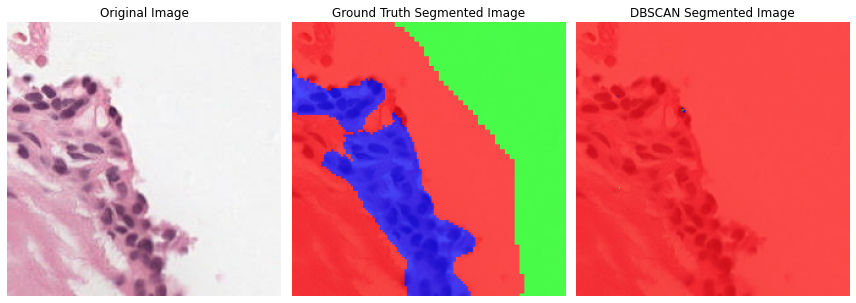

In [66]:
mask_file = mask_files[2]
image_file = image_files[2]
tile_size = 224


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_dbscan_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size,
                                              eps = 0.04,
                                              min_samples = 5)

Number of 224-sized tiles scanned: 306
green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 3)
yellow : cancerous epithelium (Gleason 4)
[0 1 2]


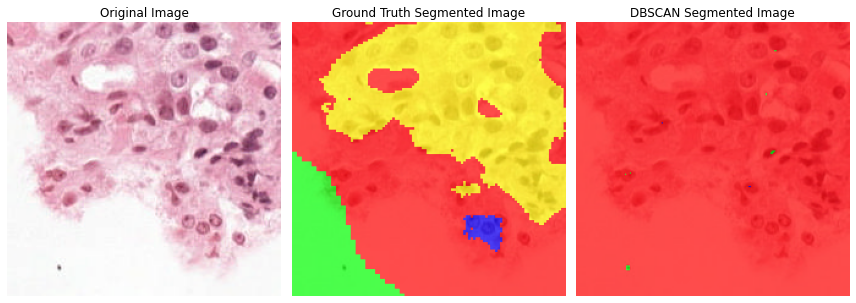

In [67]:
mask_file = mask_files[3]
image_file = image_files[3]
tile_size = 224


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_dbscan_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size,
                                              eps = 0.03,
                                              min_samples = 5)

Number of 224-sized tiles scanned: 4536
green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : healthy (benign) epithelium
[0 1]


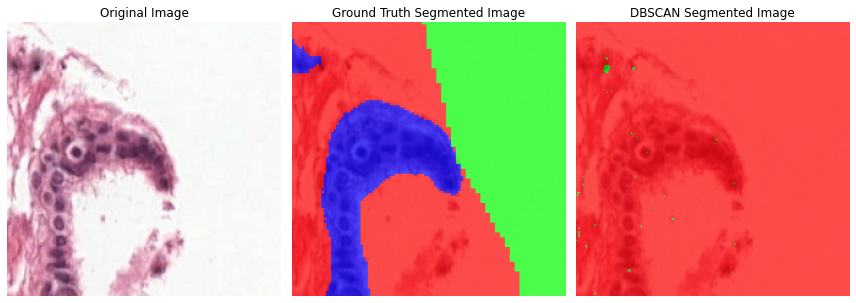

In [68]:
mask_file = mask_files[4]
image_file = image_files[4]
tile_size = 224


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_dbscan_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size,
                                              eps = 0.02,
                                              min_samples = 5)

Number of 224-sized tiles scanned: 3432
green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 4)
[0 1]


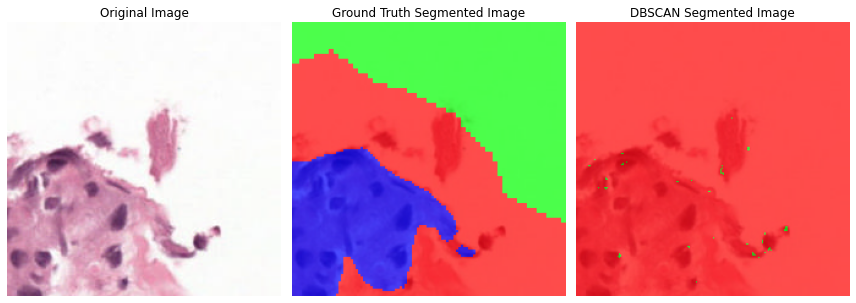

In [73]:
mask_file = mask_files[5]
image_file = image_files[5]
tile_size = 224


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_dbscan_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size,
                                              eps = 0.02,
                                              min_samples = 5)

Number of 224-sized tiles scanned: 3432
green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 4)
[0 1 2 3 4 5 6 7 8 9]


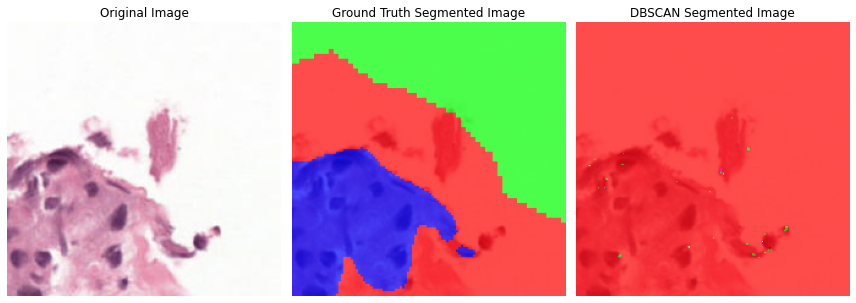

In [79]:
mask_file = mask_files[5]
image_file = image_files[5]
tile_size = 224


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_dbscan_segmentation_results(input_image = input_image,
                                              input_mask = input_mask,
                                              tile_size = tile_size,
                                              eps = 0.02,
                                              min_samples = 2)